# 2.1 Exploratory data analysis
Exploratory data analysis has been described in `data_analysis.ipnb`.

# 2.2 Data preprocessing

## 2.2.1 Loading images from the dataset
We use `image_dataset_from_directory` from tensorflow to load images in batches of size 64.

In [1]:
from tensorflow.keras.utils import image_dataset_from_directory

data_dir = "dataset/"

test_ds, train_ds, valid_ds = [
    image_dataset_from_directory(
        directory=f"{data_dir}{ds_name}",
        labels="inferred",
        label_mode="categorical", 
        image_size=(128, 128),
        batch_size=64,
    )
    for ds_name in [ "test", "train", "validation" ]
]


Found 359 files belonging to 36 classes.
Found 2407 files belonging to 36 classes.
Found 360 files belonging to 36 classes.


## 2.2.2 Data augmentation
We use various transformations, namely flipping and rotating the images to increase the variety. Very similar to data augumentation in our `pytorch` model.

In [4]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
])


## 2.2.3 Buffering and Prefetching
Using profiler we found out that IO operations take a large portion of computation time of our first model (`pytorch`). Tensorflow allows caching the datasets which speeds up the process of training a significantly.

In [5]:
from tensorflow import data

train_ds = train_ds.cache().prefetch(buffer_size=data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=data.AUTOTUNE)


## 2.3 Model choice

For our model we use pretrained `ResNet50` deep neural network. The main benefit of a deep network is that it can learn features at many different levels of abstraction, for example,  edges (at the lower layers) to very complex features (at the deeper layers) in the case of an image.


In [6]:
from tensorflow.keras.applications import ResNet50
from keras import Sequential, layers

res50 = ResNet50(include_top=False, weights = 'imagenet', input_shape=(128, 128, 3))
res50.trainable = False

model = Sequential()
model.add(res50)
model.add(layers.Flatten())
model.add(layers.Activation('relu'))
model.add(layers.Dense(36))
model.add(layers.Activation('softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 activation (Activation)     (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 36)                1179684   
                                                                 
 activation_1 (Activation)   (None, 36)                0         
                                                                 
Total params: 24,767,396
Trainable params: 1,179,684
Non-trainable params: 23,587,712
_________________________________________________________________


##  2.4 Model explanation

As we can see, the `ResNet50` model has 24,767,396 parameters, of which only `1,179,684` are trainable.

Since the model is of the same architecture as the model used in our `pytorch` model (ResNet18), more detailed information about the very internals of the model's design is described in `pytorch_model.ipynb` notebook.

# 2.5 Model training
## 2.5.1 Model compilation
Before training, we first need to compile the model.

As the parameters for compiling we choose `categorical_crossentropy` loss function, which is used in multi-class classification tasks, where an example can only belong to one out of many possible categories, and the model must decide which one.

Additionally, we chose `adam` to be our optimizer, which is a smart algorithm that takes care of updating the network weights. The alternative `sgd` optimizer had no visible effects on the training results.

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 2.5.2 Model fitting

To train the model, we use use 20 epochs. This number has proven to be efficient as the training usually stops between 12th and 15th epoch thanks to `EarlyStopping` callback.

Early stopping means stopping the training once monitored metric is no longer improving. In this case, the monitoring metric is 'loss'. The `patience` parameter manages the number of epochs with no improvement after which the training will be stopped. We found optimal results with setting this value to `3` epochs.


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_ds,
    batch_size=64,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[
        EarlyStopping(
            monitor='loss',
            patience=3
        )
    ]
)


Epoch 1/20


 1/38 [..............................] - ETA: 3:51 - loss: 6.9759 - accuracy: 0.0156

 3/38 [=>............................] - ETA: 35s - loss: 13.2135 - accuracy: 0.0781

 7/38 [====>.........................] - ETA: 31s - loss: 15.6080 - accuracy: 0.1629

 9/38 [======>.......................] - ETA: 28s - loss: 14.7903 - accuracy: 0.1806

10/38 [======>.......................] - ETA: 28s - loss: 14.9740 - accuracy: 0.1875

12/38 [========>.....................] - ETA: 26s - loss: 14.6702 - accuracy: 0.2031

15/38 [==========>...................] - ETA: 23s - loss: 13.9656 - accuracy: 0.2271

17/38 [============>.................] - ETA: 21s - loss: 13.6454 - accuracy: 0.2436

22/38 [================>.............] - ETA: 16s - loss: 12.4498 - accuracy: 0.2798

23/38 [=================>............] - ETA: 15s - loss: 12.1934 - accuracy: 0.2908

38/38 [==============================] - ETA: 0s - loss: 9.7883 - accuracy: 0.3710

38/38 [==============================] - 51s 1s/step - loss: 9.7883 - accuracy: 0.3710 - val_loss: 4.0623 - val_accuracy: 0.5861
Epoch 2/20
38/38 [==============================] - 45s 1s/step - loss: 1.2080 - accuracy: 0.8558 - val_loss: 4.5918 - val_accuracy: 0.6472
Epoch 3/20
38/38 [==============================] - 82s 2s/step - loss: 0.5199 - accuracy: 0.9323 - val_loss: 5.3792 - val_accuracy: 0.6361
Epoch 4/20
38/38 [==============================] - 115s 3s/step - loss: 0.5198 - accuracy: 0.9402 - val_loss: 6.3662 - val_accuracy: 0.6139
Epoch 5/20
38/38 [==============================] - 123s 3s/step - loss: 0.3229 - accuracy: 0.9614 - val_loss: 6.0593 - val_accuracy: 0.6556
Epoch 6/20
38/38 [==============================] - 80s 2s/step - loss: 0.3488 - accuracy: 0.9580 - val_loss: 6.8732 - val_accuracy: 0.6361
Epoch 7/20
38/38 [==============================] - 84s 2s/step - loss: 0.3265 - accuracy: 0.9647 - val_loss: 6.7989 - val_accuracy: 0.6417
Epoch 8/20
38/38 [===========

## 2.5.3 Training accuracy over epochs
As we can see, the accuracy shoots up high in the very early epochs and only improves by little in the later epochs.

Without the mentioned `EarlyStopping` callback, we observed overtraining on data and decreased accuracy in later epochs.

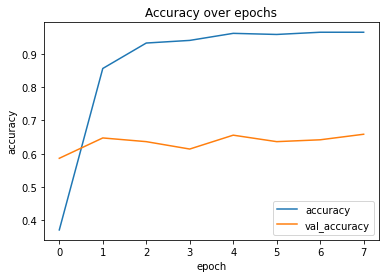

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

# 2.6 Model interpretation
The model has learned how to successfully recognize 36 classes of fruits and vegtables by adjusting it's trainable parameters.

Unfortunately, in case of neural networks, we cannot see very deep into the significance of individual image properties.

# 2.7 Model evaluation
## 2.7.1 Model accuracy
The observed accuracy on the test dataset seems to be always above the 80% threshold.

It is worth noting, that the testing dataset consists of only 10 images per class, 360 images in total, so the sample may be too small to come to a definitive conlusion.

In [10]:
model.evaluate(test_ds, verbose=1)

6/6 [==============================] - 7s 609ms/step - loss: 2.7357 - accuracy: 0.8496


[2.7356996536254883, 0.8495821952819824]

We can visualize some of the original and predicted labels for images in the test dataset.

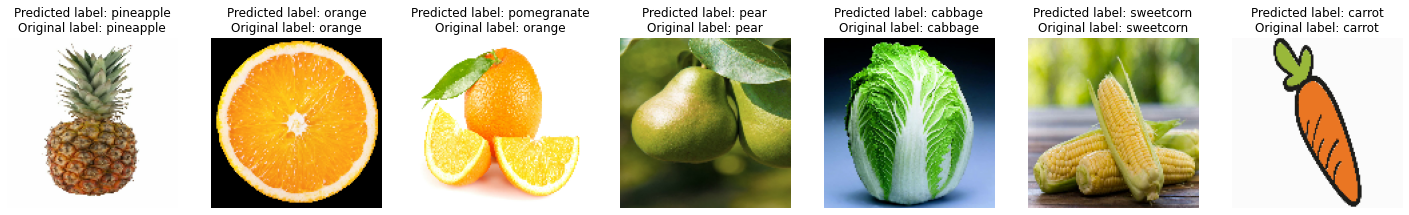

In [11]:
import tensorflow as tf

label_names = test_ds.class_names

plt.figure(figsize=(25,30))

sample_size = 7

for images, labels in test_ds.take(1):
    prediction = model.predict(images)

    for i in range(sample_size):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(images[i].numpy().astype('int'))
        
        pred_label = tf.argmax(tf.round(prediction[i]))
        orig_label = tf.argmax(labels[i])
        
        plt.title(f"Predicted label: {label_names[pred_label]}\n"
                  f"Original label: {label_names[orig_label]}")

        plt.grid(True)
        plt.axis('off')
        
    plt.show()



## 2.7.2 Confusion matrix

Plotting the confusion matrix of the test dataset can tell us more about results of the model, especially about which classes are the most likely to be misclassified. In our case, class `sweetcorn` and `corn` seem to be mistaken the most, probably due to very similar appearance.

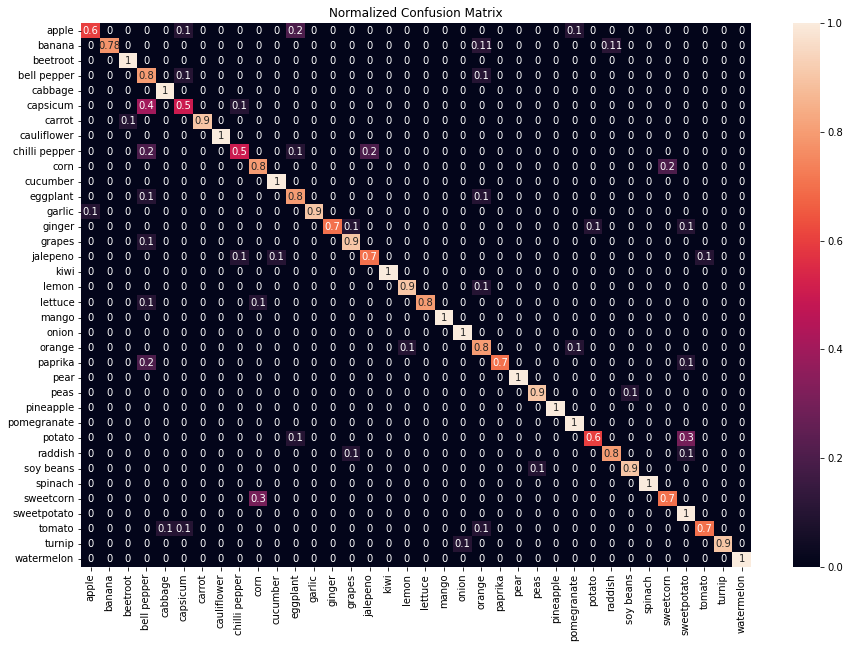

In [12]:
import numpy as np


def get_label_names(labels):
    label_names = test_ds.class_names
    label_indices = [tf.argmax(label) for label in labels]
    return [label_names[i] for i in label_indices]

images, labels = tuple(zip(*test_ds))

# "De-batch" images and labels from batches of 64
images = np.concatenate(images)
labels = np.concatenate(labels)

pred = tf.round(model.predict(images))

y_pred = get_label_names(pred)
y_test = get_label_names(labels)


from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )

plt.title('Normalized Confusion Matrix')
plt.show()
